In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
words = merged_data[1]
tags = merged_data[2]

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)

In [6]:
num_words = max([len(tokenizer.word_index)]) + 1
max_len = max([len(i) for i in words])
print("Vocab size: ", num_words)
print("Max length: ", max_len)

Vocab size:  22705
Max length:  44


In [7]:
unique_tags = np.unique(tags)
num_tags = len(np.unique(tags))
# print(num_tags)
print(unique_tags)

['EN' 'ID' 'JV' 'MIX-ID-EN' 'MIX-ID-JV' 'MIX-JV-EN' 'O']


In [8]:
X_train = x_to_padded(train_data[1], max_len)
y_train = pd.get_dummies(train_data[2])
X_val = x_to_padded(val_data[1], max_len)
y_val = pd.get_dummies(val_data[2])
X_test = x_to_padded(test_data[1], max_len)
y_test = pd.get_dummies(test_data[2])

In [9]:
model = cnn_blstm_model(num_words, num_tags, max_len)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 50)       1135250     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 43, 64)       6464        ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 43, 64)       0           ['conv1d[0][0]']                 
                                                                                              

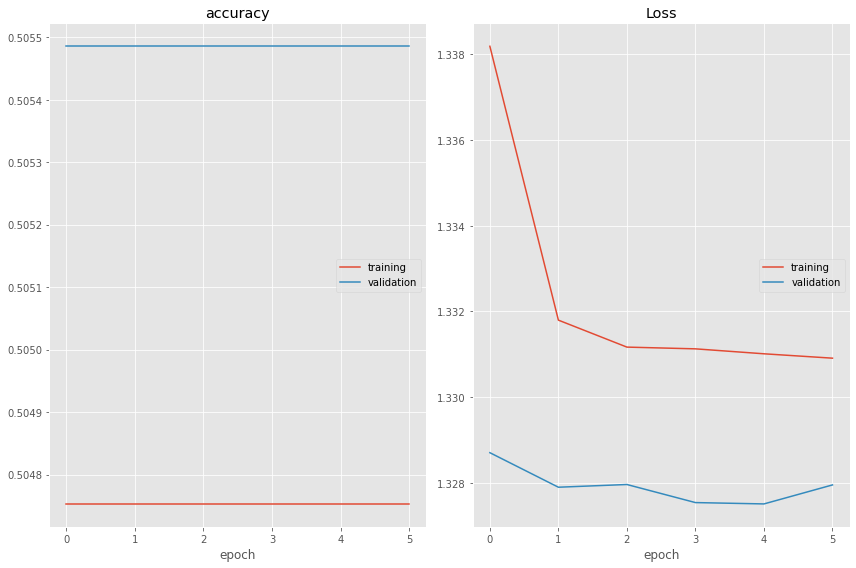

accuracy
	training         	 (min:    0.505, max:    0.505, cur:    0.505)
	validation       	 (min:    0.505, max:    0.505, cur:    0.505)
Loss
	training         	 (min:    1.331, max:    1.338, cur:    1.331)
	validation       	 (min:    1.328, max:    1.329, cur:    1.328)

Epoch 6: val_loss did not improve from 1.32751
1374/1374 [==============================] - 9s 7ms/step - loss: 1.3244 - accuracy: 0.5079
[1.324385643005371, 0.5078519582748413]


In [10]:
root_path = 'model/'
model_name = 'cnn_blstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [11]:
#Get encoded label
y_test['encoded_label'] = y_test.values.argmax(1)
print(y_test['encoded_label'])
y_test_value = y_test['encoded_label']

0        1
1        1
2        0
3        1
4        6
        ..
43933    6
43934    1
43935    6
43936    6
43937    6
Name: encoded_label, Length: 43938, dtype: int64


In [12]:
y_test_result = history.model.predict(X_test)
y_pred = np.argmax(y_test_result, axis=-1)

In [13]:
idx_tag = tag2idx(unique_tags, 0)
idx_tag

{'EN': 0,
 'ID': 1,
 'JV': 2,
 'MIX-ID-EN': 3,
 'MIX-ID-JV': 4,
 'MIX-JV-EN': 5,
 'O': 6}

In [14]:
y_test_actual = []
for value in y_test_value:
    label = [k for k,v in idx_tag.items() if v == value]
    y_test_actual.append(label)

y_pred_ = []
for value in y_pred:
    label = [k for k,v in idx_tag.items() if v == value]
    y_pred_.append(label)

/Users/ahmadfathanhidayatullah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          ID     0.5079    1.0000    0.6736     22314
          JV     0.0000    0.0000    0.0000      4914
          EN     0.0000    0.0000    0.0000      5017
   MIX-ID-EN     0.0000    0.0000    0.0000       973
   MIX-ID-JV     0.0000    0.0000    0.0000       280
   MIX-JV-EN     0.0000    0.0000    0.0000       277
           O     0.0000    0.0000    0.0000     10163

    accuracy                         0.5079     43938
   macro avg     0.0726    0.1429    0.0962     43938
weighted avg     0.2579    0.5079    0.3421     43938



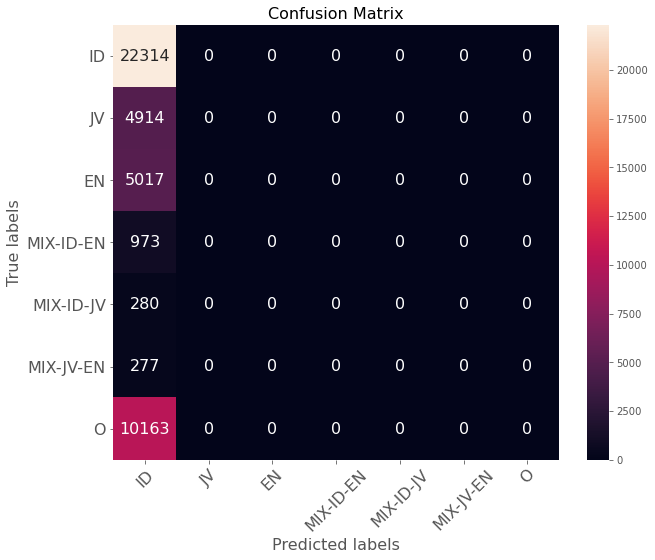

In [15]:
performance_report(y_test_actual, y_pred_)